In [29]:
import polars as pl

GAME_CAT_COLUMNS = [
    "GAME_CAT"
]

def get_feature_columns(df: pl.DataFrame, prefixes, extra_columns=None):
    """
    Gets all feature columns based on prefixes.
    """
    if extra_columns is None:
        extra_columns = []
    feature_columns = []
    for prefix in prefixes:
        matching_cols = [col for col in df.columns if col.startswith(prefix)]
        feature_columns.extend(matching_cols)
    feature_columns.extend(extra_columns)
    return feature_columns

# Read data
df = pl.read_json("game_data.json")

# Extract category names from column names
columns = get_feature_columns(df, GAME_CAT_COLUMNS)
categories = []
for column in columns:
    categories.append(column.split('GAME_CAT_')[1])

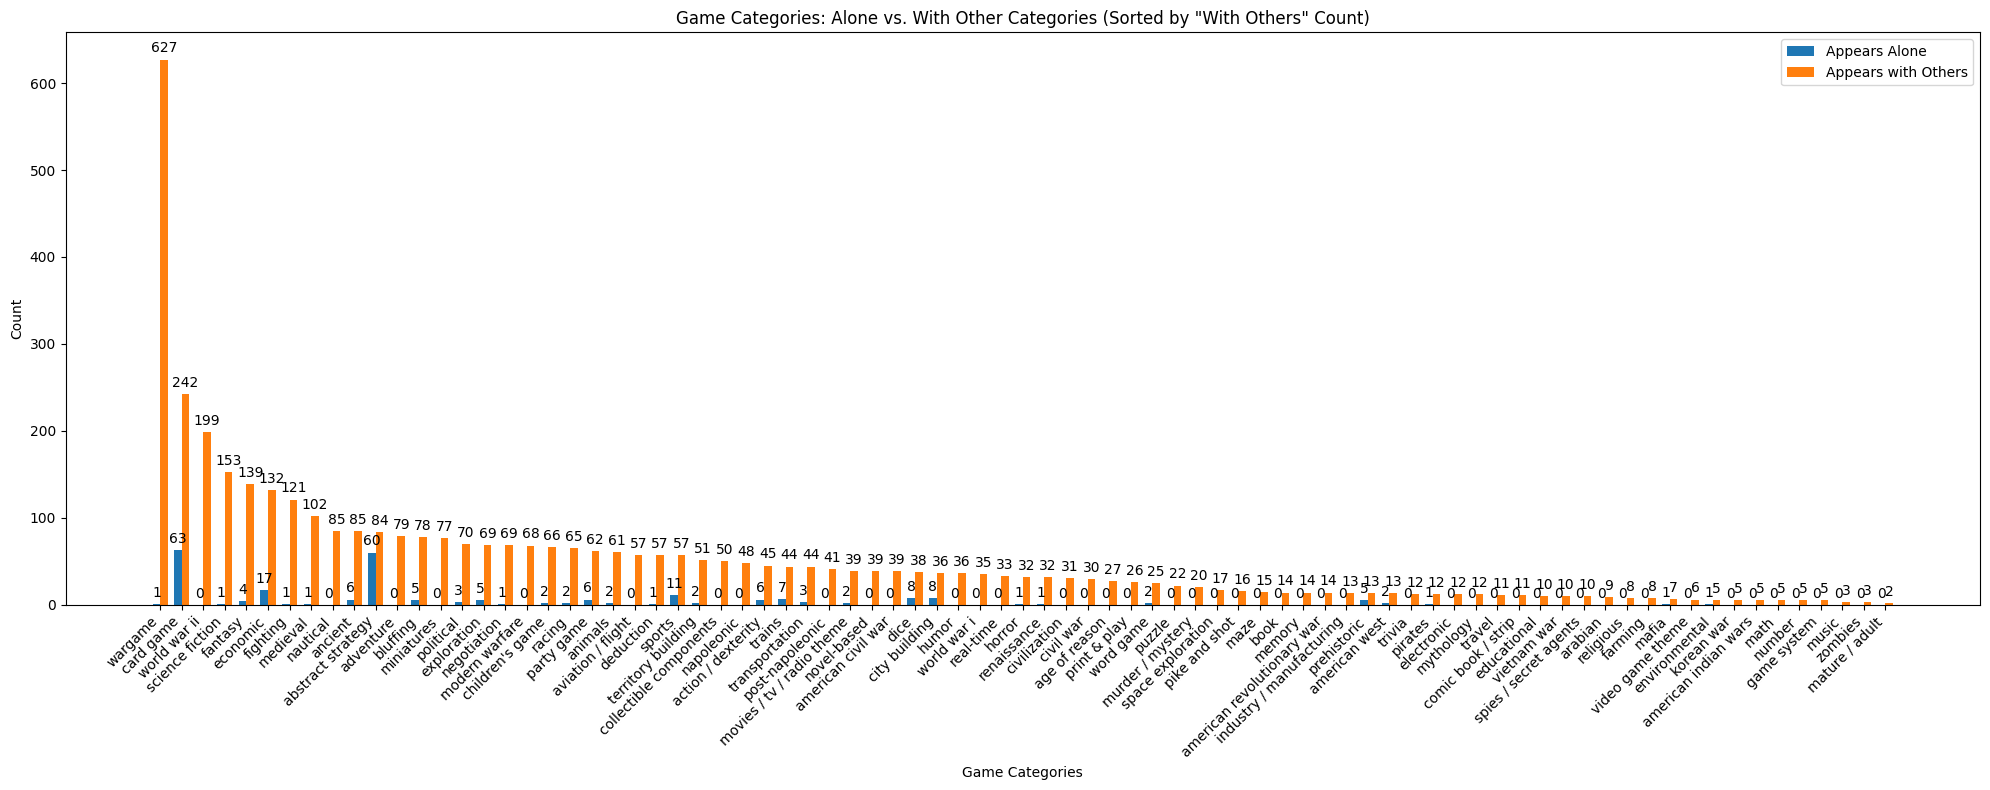

In [2]:
import matplotlib.pyplot as plt
import numpy as np

alone_counts = {cat: 0 for cat in categories}
with_others_counts = {cat: 0 for cat in categories}

for row in df.to_dicts():
    # Get the active categories for this game
    active_cats = []
    for cat in categories:
        column_name = f"GAME_CAT_{cat}"
        if column_name in row and row[column_name] == 1:
            active_cats.append(cat)
    
    # Count appearances
    if len(active_cats) == 1:
        # This category appears alone
        alone_counts[active_cats[0]] += 1
    elif len(active_cats) > 1:
        # These categories appear with others
        for cat in active_cats:
            with_others_counts[cat] += 1

# Sort categories by the number of times they appear with others (descending)
sorted_categories = sorted(categories, key=lambda cat: with_others_counts[cat], reverse=True)

# Create the visualization
fig, ax = plt.subplots(figsize=(20, 8))

# Position of the bars on the x-axis
x = np.arange(len(sorted_categories))
width = 0.35

# Create the bars
alone_bars = ax.bar(x - width/2, [alone_counts[cat] for cat in sorted_categories], width, label='Appears Alone')
with_others_bars = ax.bar(x + width/2, [with_others_counts[cat] for cat in sorted_categories], width, label='Appears with Others')

# Add labels, title and legend
ax.set_xlabel('Game Categories')
ax.set_ylabel('Count')
ax.set_title('Game Categories: Alone vs. With Other Categories (Sorted by "With Others" Count)')
ax.set_xticks(x)
ax.set_xticklabels(sorted_categories, rotation=45, ha='right')
ax.legend()

# Add counts as labels on the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(alone_bars)
add_labels(with_others_bars)

plt.tight_layout()
plt.show()

In [3]:
# Calculate percentages for analysis
total_appearances = {cat: alone_counts[cat] + with_others_counts[cat] for cat in categories}
alone_percentage = {cat: (alone_counts[cat] / total_appearances[cat] * 100) if total_appearances[cat] > 0 else 0 for cat in categories}
with_others_percentage = {cat: (with_others_counts[cat] / total_appearances[cat] * 100) if total_appearances[cat] > 0 else 0 for cat in categories}


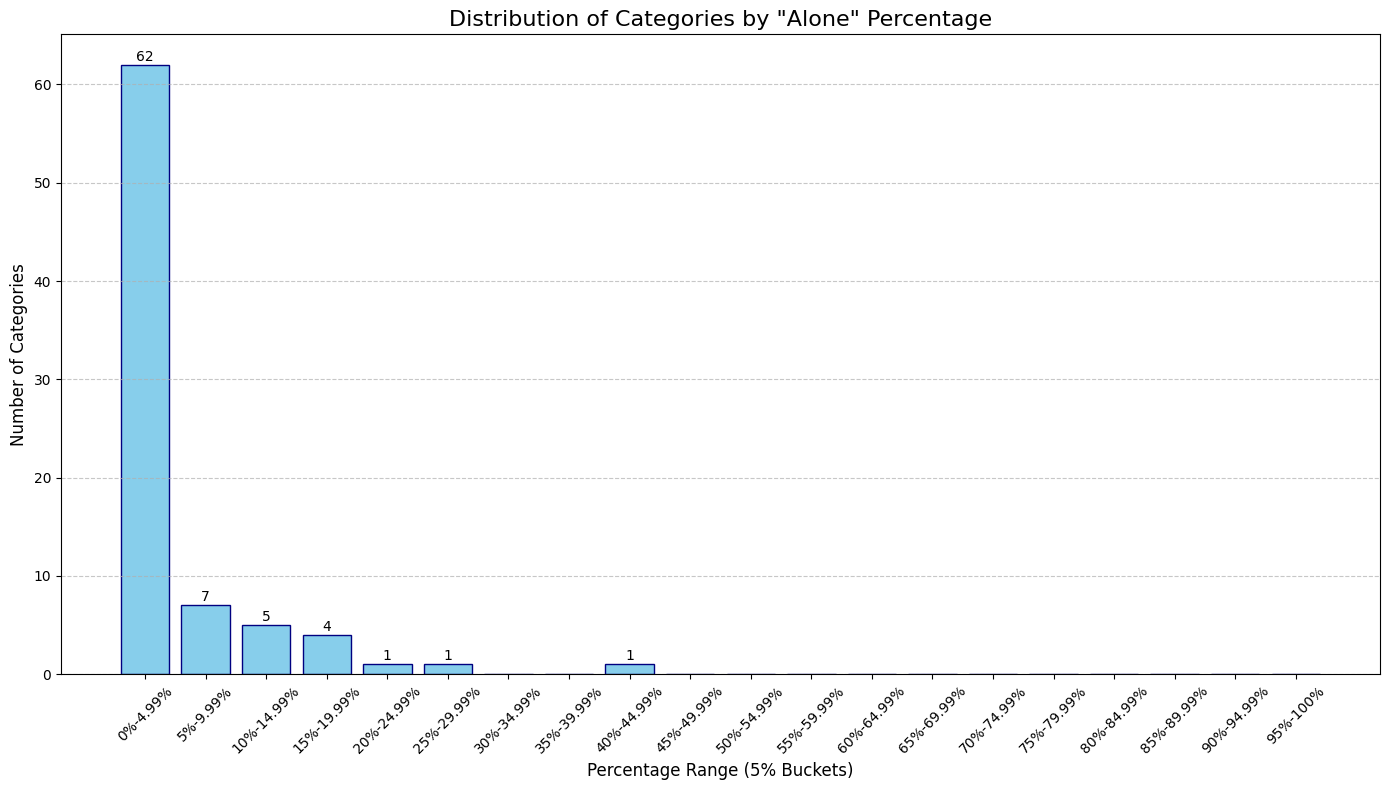

In [4]:
from collections import Counter

# Create 5% buckets from 0% to 100%
buckets = [i for i in range(0, 101, 5)]
labels = [f"{i}%-{i+4.99:.2f}%" for i in range(0, 100, 5)]
labels[-1] = "95%-100%"

# Assign each category to its bucket
category_buckets = {}
for cat in categories:
    percentage = alone_percentage[cat]
    bucket_index = min(int(percentage // 5), 19)
    category_buckets[cat] = bucket_index

# Count how many categories are in each bucket
bucket_counts = Counter(category_buckets.values())
bucket_distribution = [bucket_counts.get(i, 0) for i in range(len(buckets)-1)]

# Create a histogram
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(labels, bucket_distribution, color='skyblue', edgecolor='navy')

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom')

# Add titles and labels
ax.set_title('Distribution of Categories by "Alone" Percentage', fontsize=16)
ax.set_xlabel('Percentage Range (5% Buckets)', fontsize=12)
ax.set_ylabel('Number of Categories', fontsize=12)
plt.xticks(rotation=45)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [5]:
above_5 = []
below_5 = []
for category in alone_percentage:
    if alone_percentage[category] < 5:
        below_5.append(category)
    else:
        above_5.append(category)

In [6]:
print("\nSummary - Above 5%:")
print("-" * 50)
for category in above_5:
        print(f"- {category}")


Summary - Above 5%:
--------------------------------------------------
- dice
- economic
- environmental
- exploration
- card game
- abstract strategy
- bluffing
- word game
- action / dexterity
- prehistoric
- pirates
- city building
- sports
- ancient
- mafia
- trains
- transportation
- american west
- party game


In [7]:
print("\nSummary - Below 5%:")
print("-" * 50)
for category in below_5:
        print(f"- {category}")


Summary - Below 5%:
--------------------------------------------------
- post-napoleonic
- murder / mystery
- industry / manufacturing
- world war i
- book
- nautical
- world war ii
- korean war
- maze
- animals
- movies / tv / radio theme
- memory
- novel-based
- science fiction
- travel
- video game theme
- american revolutionary war
- religious
- horror
- renaissance
- miniatures
- political
- real-time
- negotiation
- american civil war
- civil war
- american indian wars
- children's game
- puzzle
- trivia
- educational
- aviation / flight
- modern warfare
- deduction
- music
- collectible components
- pike and shot
- medieval
- vietnam war
- arabian
- comic book / strip
- mature / adult
- math
- humor
- age of reason
- fighting
- number
- space exploration
- electronic
- spies / secret agents
- wargame
- racing
- civilization
- mythology
- zombies
- fantasy
- farming
- adventure
- game system
- territory building
- napoleonic
- print & play


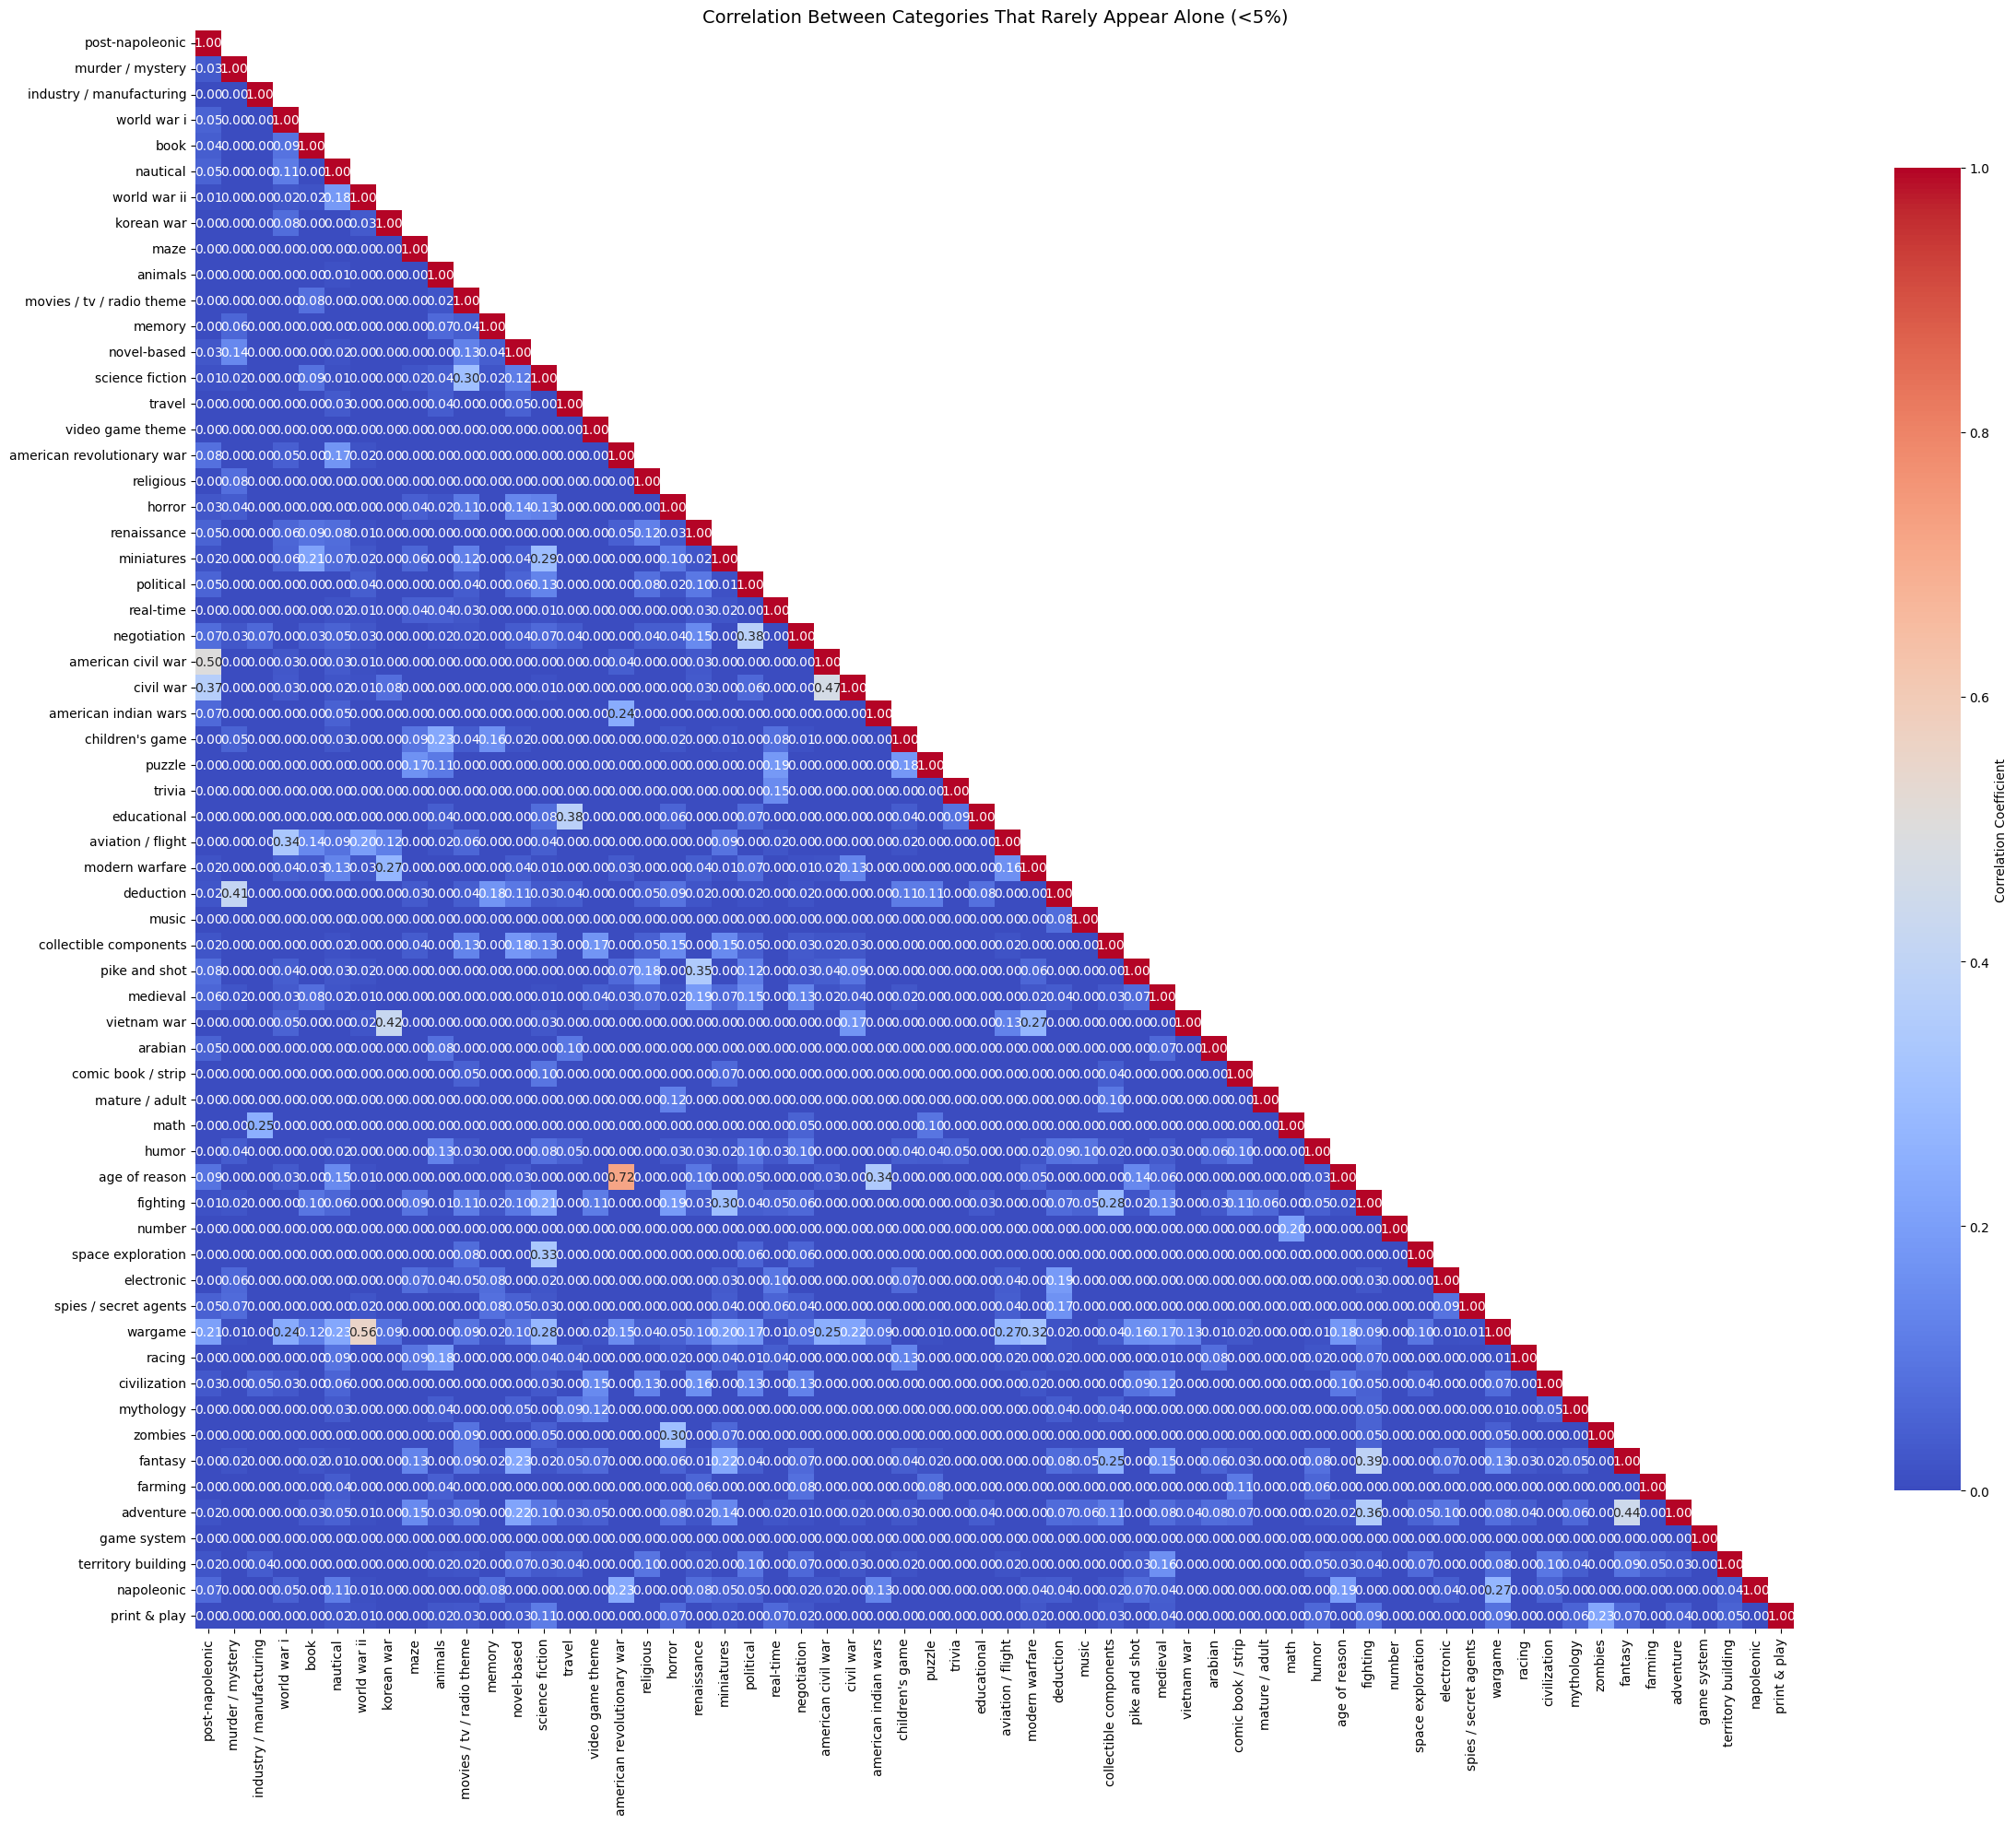


Top 10 Strongest Category Correlations:
--------------------------------------------------
1. american revolutionary war + age of reason: 0.720
2. world war ii + wargame: 0.557
3. post-napoleonic + american civil war: 0.500
4. american civil war + civil war: 0.468
5. fantasy + adventure: 0.442
6. korean war + vietnam war: 0.424
7. murder / mystery + deduction: 0.411
8. fighting + fantasy: 0.394
9. travel + educational: 0.381
10. political + negotiation: 0.378

Category Clusters (categories with correlation > 0.7):
--------------------------------------------------
Cluster 1: american revolutionary war, age of reason


In [8]:
import seaborn as sns

# Extract co-occurrence data for these categories
# Initialize co-occurrence matrix
n_categories = len(below_5)
co_occurrence = np.zeros((n_categories, n_categories))

# For each row in the dataframe
for row in df.to_dicts():
    # Get the active categories for this game
    active_cats = []
    for cat in below_5:
        column_name = f"GAME_CAT_{cat}"
        if column_name in row and row[column_name] == 1:
            active_cats.append(cat)
    
    # Update co-occurrence matrix
    for i, cat1 in enumerate(active_cats):
        idx1 = below_5.index(cat1)
        # Include self-correlation (diagonal)
        co_occurrence[idx1, idx1] += 1
        # Include co-occurrences with other categories
        for j, cat2 in enumerate(active_cats[i+1:], i+1):
            idx2 = below_5.index(cat2)
            co_occurrence[idx1, idx2] += 1
            co_occurrence[idx2, idx1] += 1

# Convert to correlation coefficients
# First get the occurrences of each category (diagonal of co-occurrence)
category_occurrences = np.diag(co_occurrence)
correlation_matrix = np.zeros((n_categories, n_categories))

for i in range(n_categories):
    for j in range(n_categories):
        if i == j:
            correlation_matrix[i, j] = 1.0  # Self-correlation is always 1
        else:
            # Correlation formula: co-occurrences / sqrt(occurrences_i * occurrences_j)
            # This is similar to cosine similarity
            if category_occurrences[i] > 0 and category_occurrences[j] > 0:
                correlation_matrix[i, j] = co_occurrence[i, j] / np.sqrt(category_occurrences[i] * category_occurrences[j])
            else:
                correlation_matrix[i, j] = 0

# Visualize the correlation matrix
plt.figure(figsize=(24, 20))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  # Show only lower triangle
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            xticklabels=below_5,
            yticklabels=below_5,
            vmin=0, vmax=1,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8, "label": "Correlation Coefficient"})

plt.title('Correlation Between Categories That Rarely Appear Alone (<5%)', fontsize=14)
plt.tight_layout()
plt.show()

# Find the strongest correlations
print("\nTop 10 Strongest Category Correlations:")
print("-" * 50)
correlations = []
for i in range(n_categories):
    for j in range(i+1, n_categories):  # Only lower triangle to avoid duplicates
        cat1 = below_5[i]
        cat2 = below_5[j]
        corr_value = correlation_matrix[i, j]
        correlations.append((cat1, cat2, corr_value))

# Sort by correlation value (descending)
correlations.sort(key=lambda x: x[2], reverse=True)

# Print top 10 correlations
for i, (cat1, cat2, corr) in enumerate(correlations[:10], 1):
    print(f"{i}. {cat1} + {cat2}: {corr:.3f}")
    
# Also identify clusters of highly correlated categories
print("\nCategory Clusters (categories with correlation > 0.7):")
print("-" * 50)
clusters = []
visited = set()

for i in range(n_categories):
    if below_5[i] in visited:
        continue
        
    cluster = [below_5[i]]
    visited.add(below_5[i])
    
    for j in range(n_categories):
        if i != j and correlation_matrix[i, j] > 0.7:
            cluster.append(below_5[j])
            visited.add(below_5[j])
            
    if len(cluster) > 1:  # Only show clusters with at least 2 categories
        clusters.append(cluster)

for i, cluster in enumerate(clusters, 1):
    print(f"Cluster {i}: {', '.join(cluster)}")

# War Games Analysis

In [9]:
import gensim.downloader as api

# Load pre-trained word vectors
word_vectors = api.load("glove-wiki-gigaword-100")

# Find words related to "war"
try:
    war_related = [word for word, _ in word_vectors.most_similar("war", topn=5)]
    print(war_related)
except KeyError:
    print("Word not found in vocabulary")

# Find war-related categories
war_games = []
for category in below_5:
    words = category.lower().split()
    # Check if any word in the category is semantically close to war terms
    for word in words:
        try:
            if word in word_vectors and word_vectors.similarity(word, "war") > 0.4:
                war_games.append(category)
                break
        except KeyError:
            continue
    # Also include categories with "war" directly
    if "war" in category.lower() and category not in war_games:
        war_games.append(category)

['wars', 'conflict', 'invasion', 'military', 'occupation']


In [10]:
war_games

['murder / mystery',
 'world war i',
 'book',
 'world war ii',
 'korean war',
 'american revolutionary war',
 'religious',
 'horror',
 'political',
 'american civil war',
 'civil war',
 'american indian wars',
 'modern warfare',
 'pike and shot',
 'vietnam war',
 'comic book / strip',
 'age of reason',
 'fighting',
 'number',
 'spies / secret agents',
 'wargame',
 'game system',
 'territory building',
 'napoleonic']

In [11]:
war_games = [
    'korean war',
    'civil war',
    'pike and shot',
    'world war i',
    'american civil war',
    'modern warfare',
    'world war ii',
    'wargame',
    'vietnam war',
    'american indian wars',
    'fighting',
    'american revolutionary war'
]

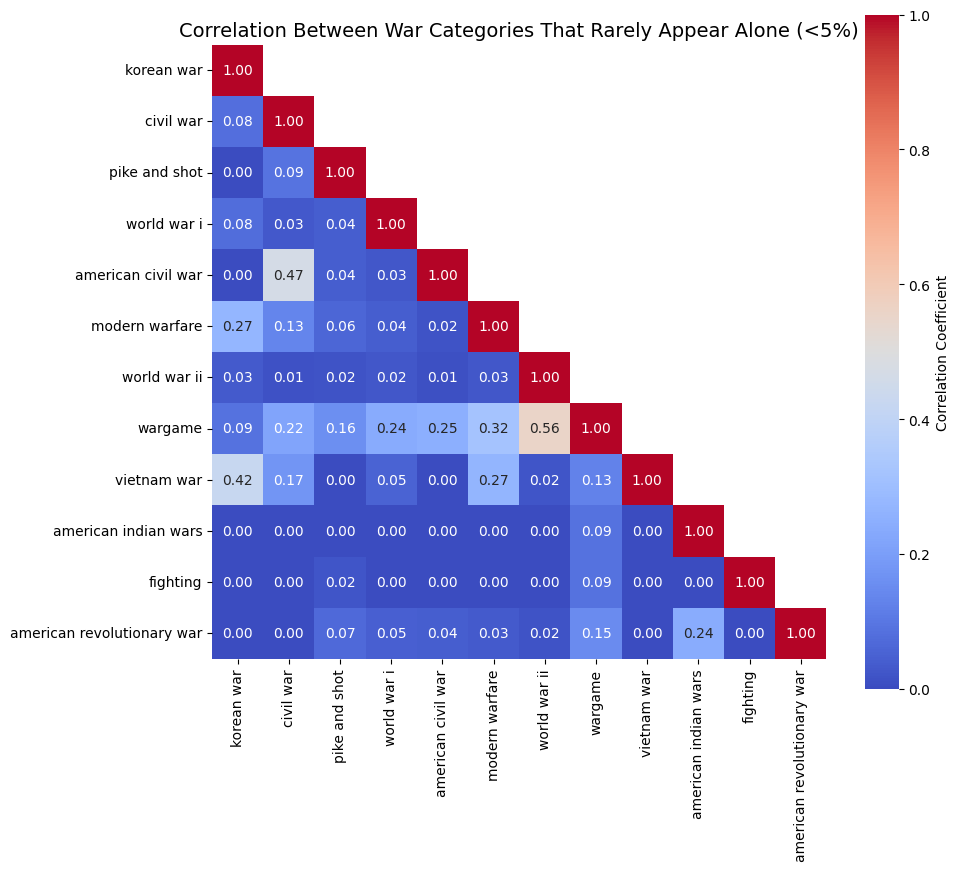

In [12]:
# Extract co-occurrence data for these categories
# Initialize co-occurrence matrix
n_categories = len(war_games)
co_occurrence = np.zeros((n_categories, n_categories))

# For each row in the dataframe
for row in df.to_dicts():
    # Get the active categories for this game
    active_cats = []
    for cat in war_games:
        column_name = f"GAME_CAT_{cat}"
        if column_name in row and row[column_name] == 1:
            active_cats.append(cat)
    
    # Update co-occurrence matrix
    for i, cat1 in enumerate(active_cats):
        idx1 = war_games.index(cat1)
        # Include self-correlation (diagonal)
        co_occurrence[idx1, idx1] += 1
        # Include co-occurrences with other categories
        for j, cat2 in enumerate(active_cats[i+1:], i+1):
            idx2 = war_games.index(cat2)
            co_occurrence[idx1, idx2] += 1
            co_occurrence[idx2, idx1] += 1

# Convert to correlation coefficients
# First get the occurrences of each category (diagonal of co-occurrence)
category_occurrences = np.diag(co_occurrence)
correlation_matrix = np.zeros((n_categories, n_categories))

for i in range(n_categories):
    for j in range(n_categories):
        if i == j:
            correlation_matrix[i, j] = 1.0
        else:
            if category_occurrences[i] > 0 and category_occurrences[j] > 0:
                correlation_matrix[i, j] = co_occurrence[i, j] / np.sqrt(category_occurrences[i] * category_occurrences[j])
            else:
                correlation_matrix[i, j] = 0

# Visualize the correlation matrix
plt.figure(figsize=(10, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  # Show only lower triangle
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            xticklabels=war_games,
            yticklabels=war_games,
            vmin=0, vmax=1,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8, "label": "Correlation Coefficient"})

plt.title('Correlation Between War Categories That Rarely Appear Alone (<5%)', fontsize=14)
plt.tight_layout()
plt.show()

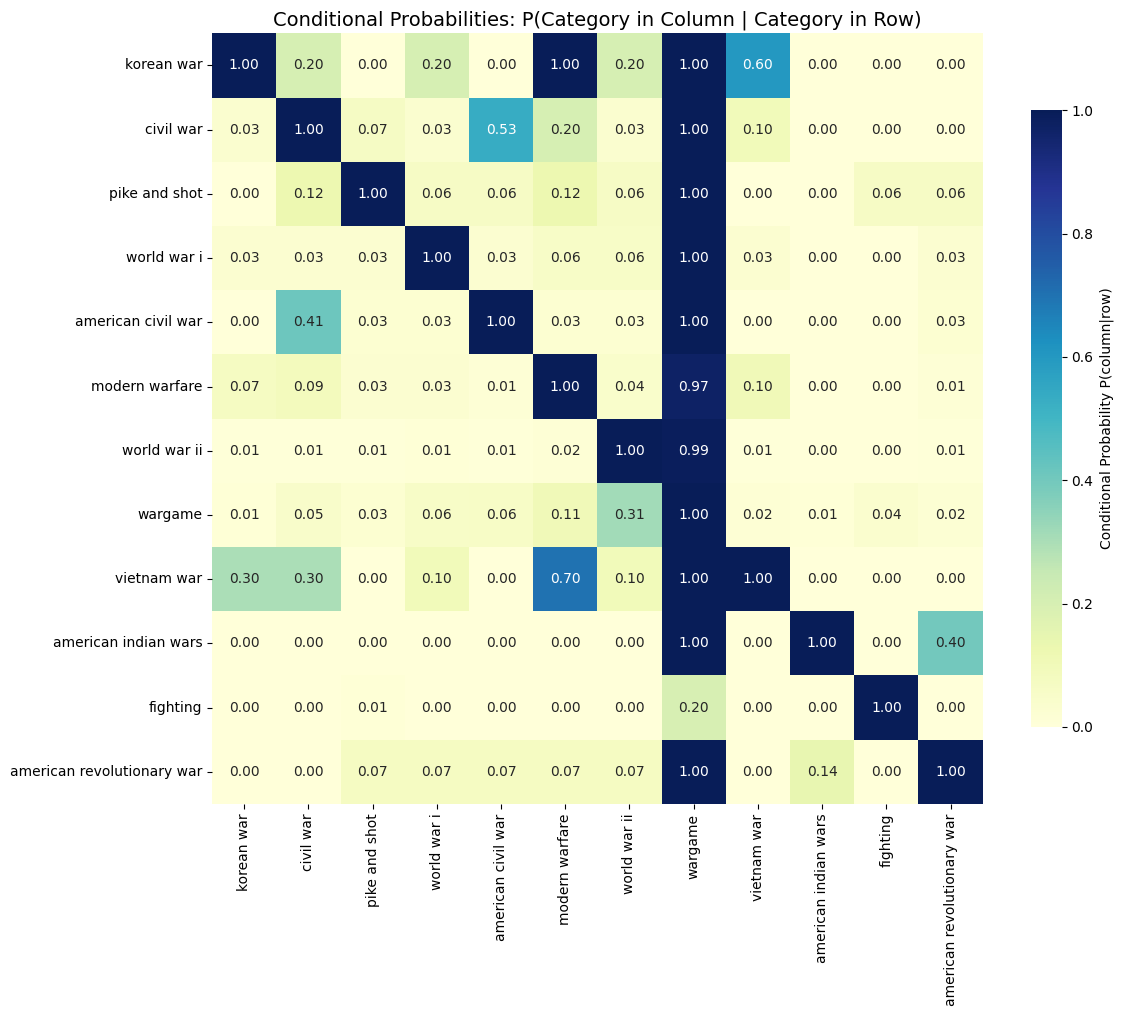


Conditional probabilities for 'wargame':
Probability of a game being tagged 'wargame' if it's tagged with:
  • 'korean war': 1.00
  • 'civil war': 1.00
  • 'pike and shot': 1.00
  • 'world war i': 1.00
  • 'american civil war': 1.00
  • 'vietnam war': 1.00
  • 'american indian wars': 1.00
  • 'american revolutionary war': 1.00
  • 'world war ii': 0.99
  • 'modern warfare': 0.97
  • 'fighting': 0.20


In [13]:
# Calculate conditional probabilities
conditional_probs = np.zeros((n_categories, n_categories))

for i in range(n_categories):
    for j in range(n_categories):
        # P(B|A) = P(A and B) / P(A) = co_occurrence[i,j] / category_occurrences[i]
        if category_occurrences[i] > 0:  # Avoid division by zero
            conditional_probs[i, j] = co_occurrence[i, j] / category_occurrences[i]
        else:
            conditional_probs[i, j] = 0

# Visualize conditional probabilities
plt.figure(figsize=(12, 10))
sns.heatmap(conditional_probs,
            annot=True,
            cmap='YlGnBu',
            xticklabels=war_games,
            yticklabels=war_games,
            vmin=0, vmax=1,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8, "label": "Conditional Probability P(column|row)"})

plt.title('Conditional Probabilities: P(Category in Column | Category in Row)', fontsize=14)
plt.tight_layout()
plt.show()

conditional_probs_copy = np.zeros((n_categories, n_categories))

for i in range(n_categories):
    for j in range(n_categories):
        if category_occurrences[i] > 0:
            conditional_probs_copy[i, j] = co_occurrence[i, j] / category_occurrences[i]
        else:
            conditional_probs_copy[i, j] = 0

# Function to print conditional probabilities for a target category
def print_conditional_probabilities_for(target_category):
    if target_category not in war_games:
        print(f"Category '{target_category}' not found in war_games")
        return
    
    target_idx = war_games.index(target_category)
    
    print(f"\nConditional probabilities for '{target_category}':")
    print("="*60)
    print(f"Probability of a game being tagged '{target_category}' if it's tagged with:")
    
    # Create a list of tuples (category, probability)
    probs_list = [(war_games[i], conditional_probs_copy[i, target_idx]) for i in range(n_categories)]
    
    # Sort by probability (highest first)
    probs_list.sort(key=lambda x: x[1], reverse=True)
    
    # Print formatted results
    for category, prob in probs_list:
        if category != target_category:  # Skip the target category itself
            print(f"  • '{category}': {prob:.2f}")

print_conditional_probabilities_for('wargame')

In [14]:
# List of categories to merge into 'wargame'
categories_to_merge = [
    'korean war',
    'civil war',
    'pike and shot',
    'world war i',
    'american civil war',
    'vietnam war',
    'american indian wars',
    'american revolutionary war',
    'world war ii',
    'modern warfare'
]

# Create a list of column names to be merged
columns_to_merge = [f"GAME_CAT_{cat}" for cat in categories_to_merge]

# Check which of these columns actually exist in the DataFrame
existing_columns = [col for col in columns_to_merge if col in df.columns]

# First, check if the wargame column exists, if not create it
if "GAME_CAT_wargame" not in df.columns:
    df = df.with_columns(pl.lit(0).alias("GAME_CAT_wargame"))

# Create a Boolean expression for all rows that have any of these categories set to 1
if existing_columns:
    # Create boolean expression for any matching column being true
    merge_expr = pl.lit(False)
    for col in existing_columns:
        merge_expr = merge_expr | (pl.col(col) == 1)
    
    # Check how many games will be newly tagged as 'wargame'
    check_expr = (pl.col("GAME_CAT_wargame") == 0) & merge_expr
    newly_tagged_count = df.filter(check_expr).height
    
    print(f"Number of games newly tagged as 'wargame': {newly_tagged_count}")
    
    # Update the wargame column: set it to 1 if any of the merged columns is 1
    df = df.with_columns(
        pl.when(merge_expr)
        .then(pl.lit(1))
        .otherwise(pl.col("GAME_CAT_wargame"))
        .alias("GAME_CAT_wargame")
    )
    
    # Count after updating
    print(f"Number of games tagged as 'wargame' after merging: {df.filter(pl.col('GAME_CAT_wargame') == 1).height}")
    
    # Drop the columns that were merged
    df = df.drop(existing_columns)
    
    print(f"Dropped {len(existing_columns)} columns after merging them into 'GAME_CAT_wargame'")
else:
    print("None of the specified category columns were found in the DataFrame")

Number of games newly tagged as 'wargame': 4
Number of games tagged as 'wargame' after merging: 632
Dropped 10 columns after merging them into 'GAME_CAT_wargame'


---

In [15]:
GAME_CAT_COLUMNS = [
    "GAME_CAT"
]

def get_feature_columns(df: pl.DataFrame, prefixes, extra_columns=None):
    """
    Gets all feature columns based on prefixes.
    """
    if extra_columns is None:
        extra_columns = []
    feature_columns = []
    for prefix in prefixes:
        matching_cols = [col for col in df.columns if col.startswith(prefix)]
        feature_columns.extend(matching_cols)
    feature_columns.extend(extra_columns)
    return feature_columns

# Extract category names from column names
columns = get_feature_columns(df, GAME_CAT_COLUMNS)
categories = []
for column in columns:
    categories.append(column.split('GAME_CAT_')[1])

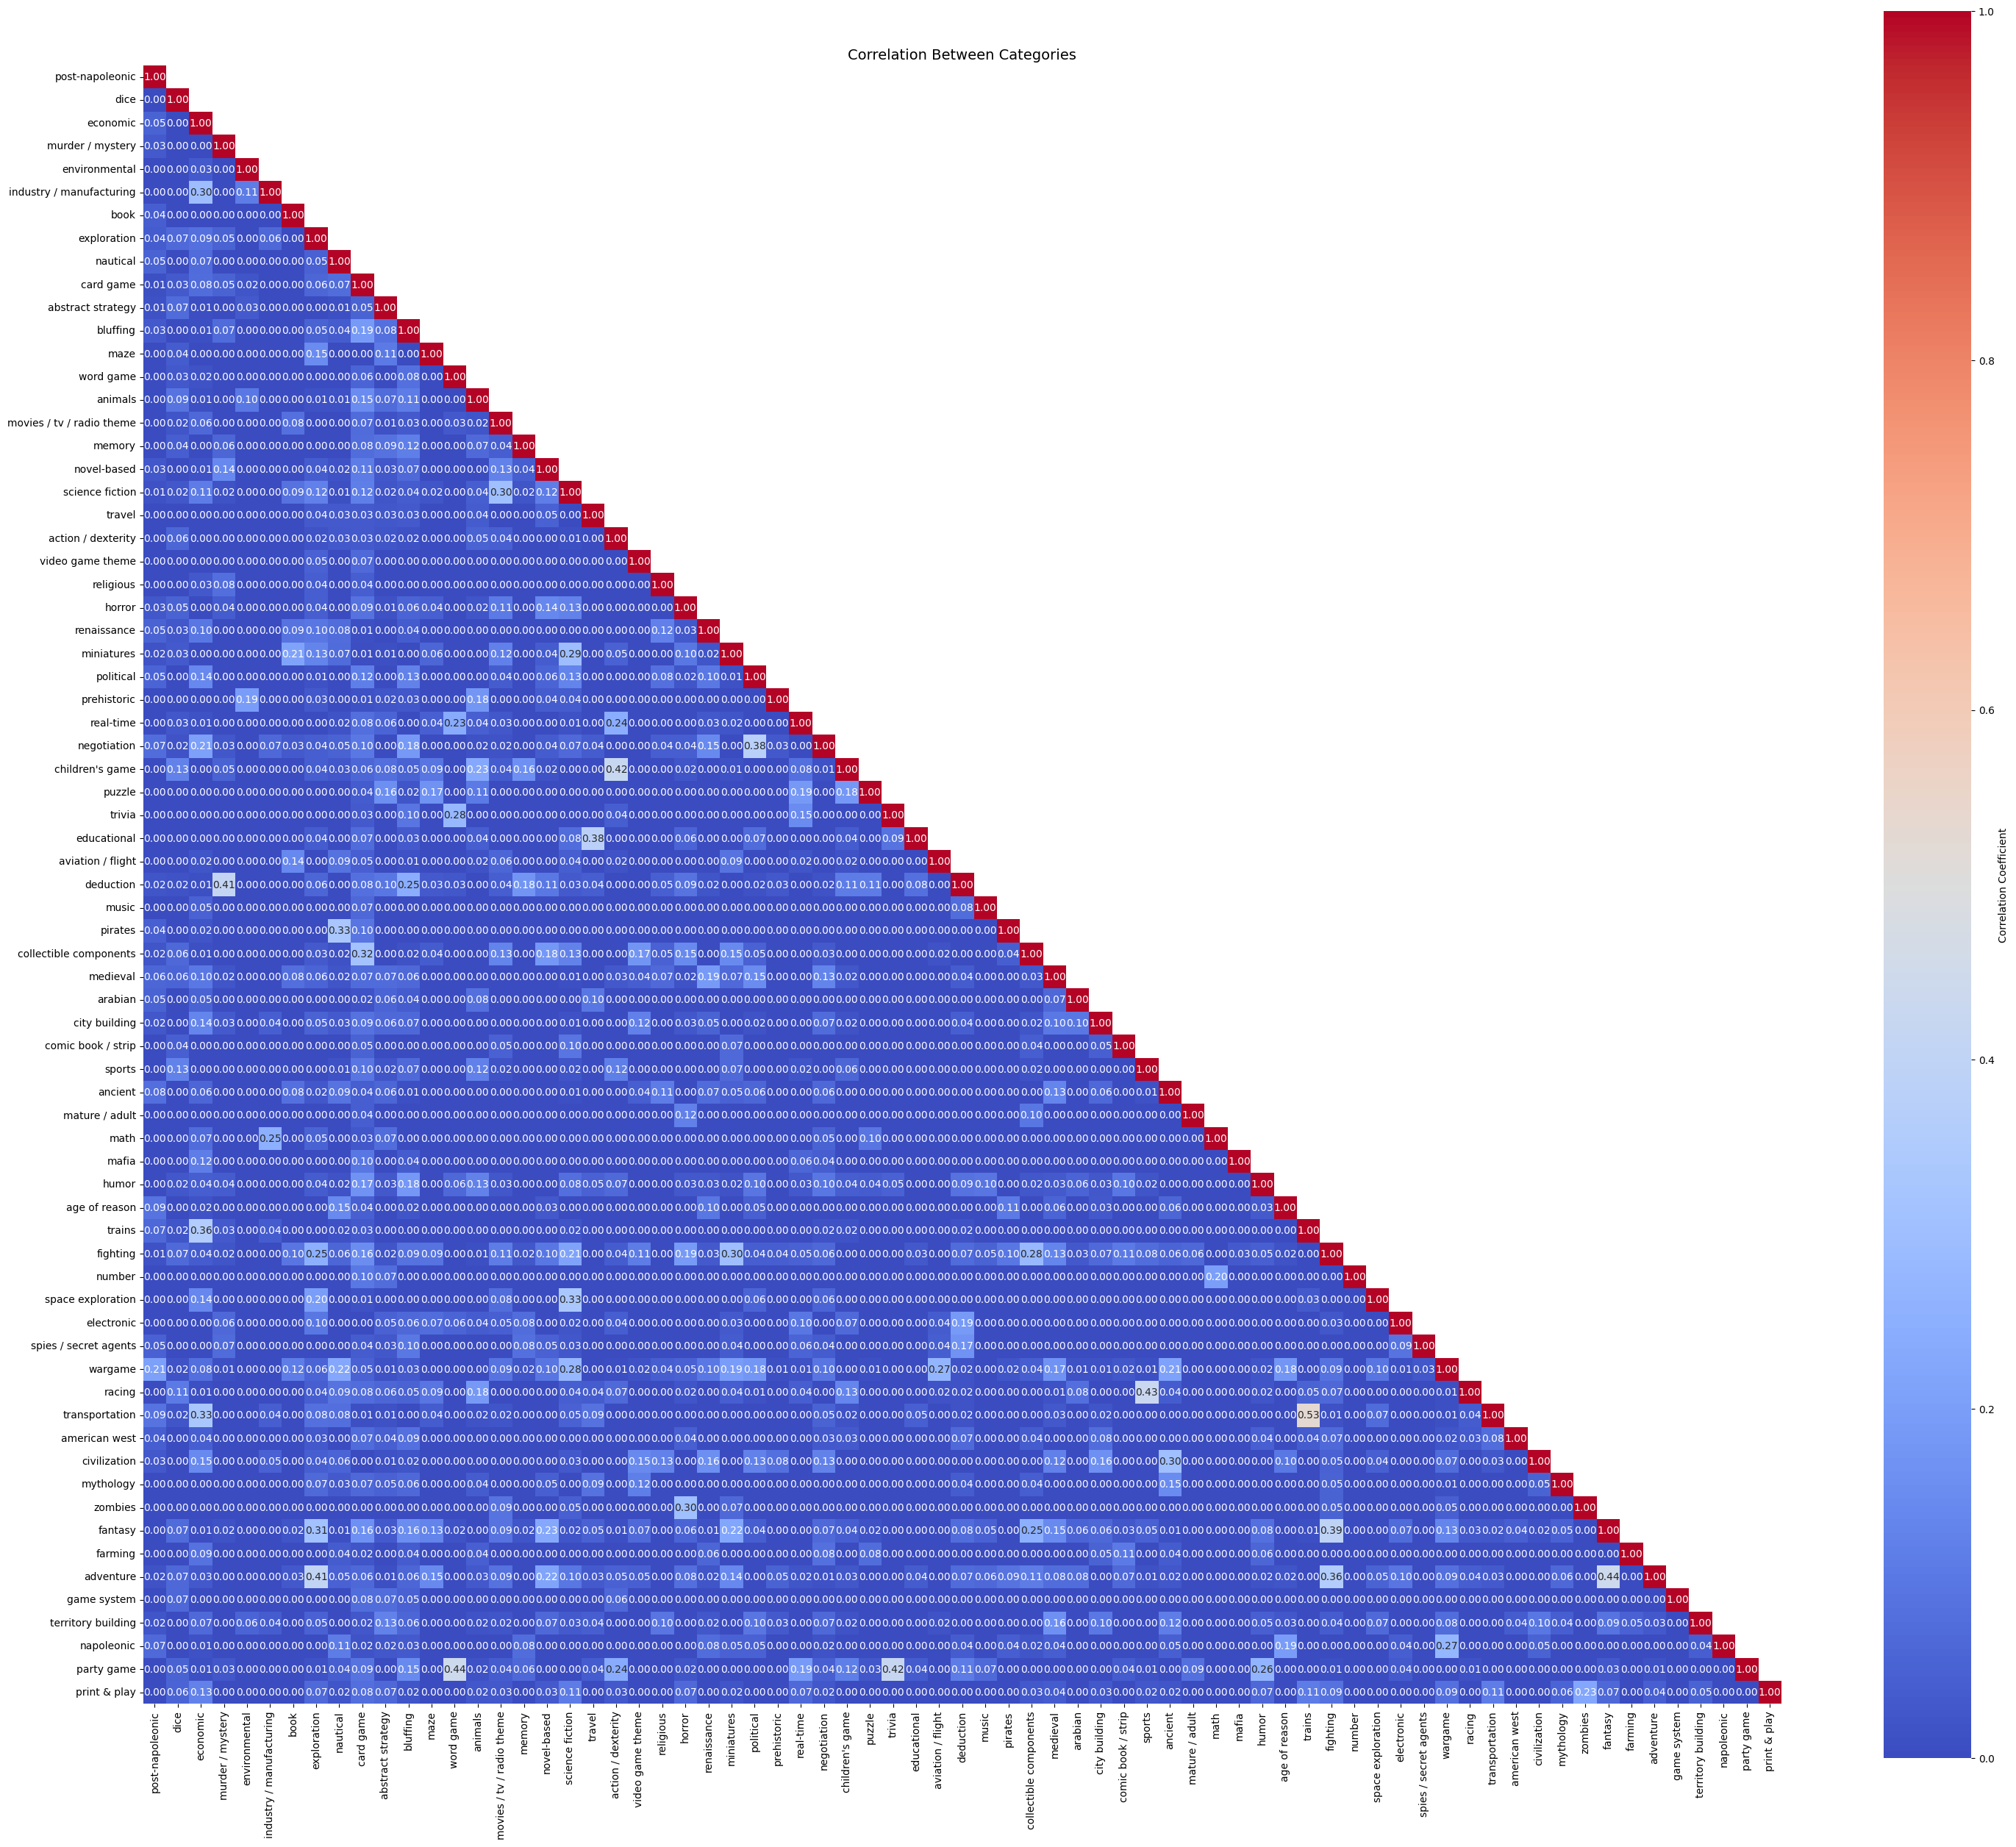

In [16]:
# Extract co-occurrence data for these categories
# Initialize co-occurrence matrix
n_categories = len(categories)
co_occurrence = np.zeros((n_categories, n_categories))

# For each row in the dataframe
for row in df.to_dicts():
    # Get the active categories for this game
    active_cats = []
    for cat in categories:
        column_name = f"GAME_CAT_{cat}"
        if column_name in row and row[column_name] == 1:
            active_cats.append(cat)
    
    # Update co-occurrence matrix
    for i, cat1 in enumerate(active_cats):
        idx1 = categories.index(cat1)
        # Include self-correlation (diagonal)
        co_occurrence[idx1, idx1] += 1
        # Include co-occurrences with other categories
        for j, cat2 in enumerate(active_cats[i+1:], i+1):
            idx2 = categories.index(cat2)
            co_occurrence[idx1, idx2] += 1
            co_occurrence[idx2, idx1] += 1

# Convert to correlation coefficients
# First get the occurrences of each category (diagonal of co-occurrence)
category_occurrences = np.diag(co_occurrence)
correlation_matrix = np.zeros((n_categories, n_categories))

for i in range(n_categories):
    for j in range(n_categories):
        if i == j:
            correlation_matrix[i, j] = 1.0
        else:
            if category_occurrences[i] > 0 and category_occurrences[j] > 0:
                correlation_matrix[i, j] = co_occurrence[i, j] / np.sqrt(category_occurrences[i] * category_occurrences[j])
            else:
                correlation_matrix[i, j] = 0

# Visualize the correlation matrix
plt.figure(figsize=(30, 30))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  # Show only lower triangle
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            xticklabels=categories,
            yticklabels=categories,
            vmin=0, vmax=1,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8, "label": "Correlation Coefficient"})

plt.title('Correlation Between Categories', fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
# Finding all category pairs with probability > 0.9
high_prob_pairs = []

conditional_probs_copy = np.zeros((n_categories, n_categories))

for i in range(n_categories):
    for j in range(n_categories):
        if category_occurrences[i] > 0:
            conditional_probs_copy[i, j] = co_occurrence[i, j] / category_occurrences[i]
        else:
            conditional_probs_copy[i, j] = 0
            
for i in range(n_categories):
    for j in range(n_categories):
        if i != j:  # Skip self-relationships
            if conditional_probs_copy[i, j] >= 0.9:
                high_prob_pairs.append((
                    categories[i], 
                    categories[j],  
                    conditional_probs_copy[i, j]  
                ))

# Sort by probability (highest first)
high_prob_pairs.sort(key=lambda x: x[2], reverse=True)

# Print the results
print("\nHigh probability category relationships (>=90%):")
print("="*75)
print(f"{'Category A':<25} | {'Category B':<25} | Probability P(B|A)")
print("-"*75)

for cat_a, cat_b, prob in high_prob_pairs:
    print(f"{cat_a:<25} | {cat_b:<25} | {prob:.2f}")

# Count by source category
source_counts = {}
for cat_a, _, _ in high_prob_pairs:
    if cat_a not in source_counts:
        source_counts[cat_a] = 0
    source_counts[cat_a] += 1

print("\nCategories that strongly imply other categories:")
print("="*50)
for cat, count in sorted(source_counts.items(), key=lambda x: x[1], reverse=True):
    if count > 1:  # Only show categories that imply multiple others
        print(f"{cat}: implies {count} other categories with >=90% probability")

# Count by target category
target_counts = {}
for _, cat_b, _ in high_prob_pairs:
    if cat_b not in target_counts:
        target_counts[cat_b] = 0
    target_counts[cat_b] += 1

print("\nCategories that are strongly implied by other categories:")
print("="*50)
for cat, count in sorted(target_counts.items(), key=lambda x: x[1], reverse=True):
    if count > 1:  # Only show categories that are implied by multiple others
        print(f"{cat}: implied by {count} other categories with >=90% probability")


High probability category relationships (>=90%):
Category A                | Category B                | Probability P(B|A)
---------------------------------------------------------------------------
industry / manufacturing  | economic                  | 1.00
trivia                    | party game                | 1.00
space exploration         | science fiction           | 1.00
zombies                   | horror                    | 1.00
napoleonic                | wargame                   | 0.98

Categories that strongly imply other categories:

Categories that are strongly implied by other categories:


In [20]:
# Define the high probability relationships we want to merge
category_relationships = [
    ('space exploration', 'science fiction'),           
    ('zombies', 'horror'),                     
    ('industry / manufacturing', 'economic'),                
]

# For each relationship, we'll update the target column and then remove the source column
for source_category, target_category in category_relationships:
    source_col = f"GAME_CAT_{source_category}"
    target_col = f"GAME_CAT_{target_category}"
    
    # Check if both columns exist
    if source_col in df.columns and target_col in df.columns:
        print(f"Processing: {source_category} → {target_category}")
        
        # Count original values
        source_count = df.filter(pl.col(source_col) == 1).height
        target_count_before = df.filter(pl.col(target_col) == 1).height
        
        # Update the target column: if source is 1, set target to 1
        df = df.with_columns([
            pl.when(pl.col(source_col) == 1)
            .then(pl.lit(1))
            .otherwise(pl.col(target_col))
            .alias(target_col)
        ])
        
        # Count after update
        target_count_after = df.filter(pl.col(target_col) == 1).height
        added_count = target_count_after - target_count_before
        
        print(f"  - {source_category} had {source_count} games")
        print(f"  - {target_category} had {target_count_before} games before merging")
        print(f"  - {target_category} has {target_count_after} games after merging")
        print(f"  - Added {added_count} new games to {target_category}")
        
        # Drop the source column as it's now redundant
        df = df.drop(source_col)
        print(f"  - Dropped column: {source_col}")
    else:
        # Check which column is missing
        if source_col not in df.columns:
            print(f"Source column '{source_col}' not found in dataframe")
        if target_col not in df.columns:
            print(f"Target column '{target_col}' not found in dataframe")

# Print final column count
cat_columns = [col for col in df.columns if col.startswith("GAME_CAT_")]
print(f"\nFinal number of category columns: {len(cat_columns)}")

Processing: space exploration → science fiction
  - space exploration had 17 games
  - science fiction had 154 games before merging
  - science fiction has 154 games after merging
  - Added 0 new games to science fiction
  - Dropped column: GAME_CAT_space exploration
Processing: zombies → horror
  - zombies had 3 games
  - horror had 33 games before merging
  - horror has 33 games after merging
  - Added 0 new games to horror
  - Dropped column: GAME_CAT_zombies
Processing: industry / manufacturing → economic
  - industry / manufacturing had 13 games
  - economic had 149 games before merging
  - economic has 149 games after merging
  - Added 0 new games to economic
  - Dropped column: GAME_CAT_industry / manufacturing

Final number of category columns: 68


---

In [23]:
GAME_CAT_COLUMNS = [
    "GAME_CAT"
]

def get_feature_columns(df: pl.DataFrame, prefixes, extra_columns=None):
    """
    Gets all feature columns based on prefixes.
    """
    if extra_columns is None:
        extra_columns = []
    feature_columns = []
    for prefix in prefixes:
        matching_cols = [col for col in df.columns if col.startswith(prefix)]
        feature_columns.extend(matching_cols)
    feature_columns.extend(extra_columns)
    return feature_columns

# Extract category names from column names
columns = get_feature_columns(df, GAME_CAT_COLUMNS)
categories = []
for column in columns:
    categories.append(column.split('GAME_CAT_')[1])

In [30]:
categories

['post-napoleonic',
 'dice',
 'economic',
 'murder / mystery',
 'environmental',
 'industry / manufacturing',
 'world war i',
 'book',
 'exploration',
 'nautical',
 'card game',
 'abstract strategy',
 'world war ii',
 'korean war',
 'bluffing',
 'maze',
 'word game',
 'animals',
 'movies / tv / radio theme',
 'memory',
 'novel-based',
 'science fiction',
 'travel',
 'action / dexterity',
 'video game theme',
 'american revolutionary war',
 'religious',
 'horror',
 'renaissance',
 'miniatures',
 'political',
 'prehistoric',
 'real-time',
 'negotiation',
 'american civil war',
 'civil war',
 'american indian wars',
 "children's game",
 'puzzle',
 'trivia',
 'educational',
 'aviation / flight',
 'modern warfare',
 'deduction',
 'music',
 'pirates',
 'collectible components',
 'pike and shot',
 'medieval',
 'vietnam war',
 'arabian',
 'city building',
 'comic book / strip',
 'sports',
 'ancient',
 'mature / adult',
 'math',
 'mafia',
 'humor',
 'age of reason',
 'trains',
 'fighting',
 'nu

In [ ]:
board_game_categories = {
    'time_period_historical': ['ancient', 'medieval', 'renaissance', 'age of reason', 'american west', 'arabian', 'napoleonic', 'post-napoleonic', 'prehistoric'],
    
    'military_conflict': ['world war i', 'world war ii', 'korean war', 'vietnam war', 'modern warfare', 'american revolutionary war', 'american civil war', 'civil war', 'american indian wars', 'pike and shot', 'wargame'],
    
    'based_on_media': ['movies / tv / radio theme', 'video game theme', 'book', 'novel-based', 'comic book / strip', 'music'],
    
    'crime_espionage': ['murder / mystery', 'spies / secret agents', 'mafia'],
    
    'fantasy_supernatural': ['fantasy', 'science fiction', 'mythology', 'zombies', 'pirates'],
    
    'horror': ['horror'],
    
    'resource_management': ['economic', 'industry / manufacturing', 'farming', 'city building', 'civilization', 'territory building'],
    
    'card_game': ['card game'],
    
    'physical_components': ['dice', 'miniatures', 'collectible components'],
    
    'print_and_play': ['print & play'],
    
    'memory': ['memory'],
    
    'trivia': ['trivia'],
    
    'deduction': ['deduction'],
    
    'vehicles_movement': ['aviation / flight', 'trains', 'transportation', 'racing'],
    
    'negotiation': ['negotiation', 'bluffing'],
    
    'mental_skill': ['educational', 'math', 'number', 'word game', 'puzzle'],
    
    'social_entertainment': ['party game', 'children\'s game', 'humor', 'mature / adult'],
    
    'journey_discovery': ['adventure', 'exploration', 'travel', 'maze', 'nautical', 'space exploration'],
    
    'real_world_topics': ['religious', 'political', 'environmental', 'animals'],
    
    'sports': ['sports'],
    
    'fighting': ['fighting'],
    
    'abstract_strategy': ['abstract strategy'],
    
    'real_time': ['real-time'],
    
    'action_dexterity': ['action / dexterity'],
    
    'game_system': ['game system'],

    'electronic' : ['electronic']
}

In [31]:
new_cats = []
for i in board_game_categories:
    for j in board_game_categories[i]:
        new_cats.append(j)

result = set(categories) - set(new_cats)

In [32]:
result

{'electronic'}